In [19]:
# Annual Water Use

# %%

import os, sys
import pandas as pd
from datetime import datetime

from iwateruse.featurize import MultiOneHotEncoder
from iwateruse import data_cleaning, report, splittors, pre_train_utils, make_dataset, figures
from iwateruse import denoise, model_diagnose

import matplotlib.pyplot as plt
from xgboost import plot_importance
import xgboost as xgb

#
import numpy as np
from flopy.plot import styles


import warnings

warnings.filterwarnings('ignore')
xgb.set_config(verbosity=0)

# %%
from iwateruse.model import Model
from iwateruse import targets, weights, pipelines, outliers_utils, estimators
from iwateruse import selection
from pycaret.regression import *


# %%
# =============================
# Setup Training
# =============================
figures_folder = "figs"
model = Model(name='annual_pc', log_file = 'train_log.log',  feature_status_file= r"..\features_status.xlsx")
model.raw_target = 'wu_rate'
model.target = 'per_capita'

datafile = r"..\clean_train_db.csv"
df_train = pd.read_csv(datafile)
model.add_training_df( df_train = df_train)
# make_dataset.make_ds_per_capita_basic(model, datafile=datafile)
model.df_train['pop_density']  = model.df_train['pop']/model.df_train['WSA_SQKM']
model.df_train.loc[model.df_train['WSA_SQKM']==0, 'pop_density'] = 0
# add water use
seed1 = 123
seed2 = 456

# %%
model.apply_func(func=targets.compute_per_capita, type='target_func', args=None)

opts = ['pop<=100', 'per_capita>=500', 'per_capita<=25']
model.apply_func(func=outliers_utils.drop_values, type='outliers_func', opts = opts )
model.apply_func(func = outliers_utils.drop_na_target, type='outliers_func')
model.apply_func(func=None, type='add_features_func', args=None)

# split
model.apply_func(func=splittors.random_split, args={'frac': 0.70, 'seed': seed1})


# =============================
# Prepare the initial estimator
# =============================

features = model.features
target = model.target
final_dataset = model.df_train
final_dataset = final_dataset.drop_duplicates(subset = ['sys_id', 'Year'], keep = 'first')
ignore_features = list(set(final_dataset.columns).difference(set(features + [target])))



In [20]:
# =============================
# Prepare the initial estimator
# =============================

reg1 = setup(data = final_dataset, target = target, ignore_features = ignore_features,
             fold=5, fold_shuffle = True,
             train_size = 0.7)

# compare models
learning_algorithems = ['xgboost', 'rf', 'lightgbm', 'et'] # include = learning_algorithems
#best = compare_models(n_select = 5)





,Description,Value
0,session_id,7357
1,Target,per_capita
2,Original Data,"(74753, 122)"
3,Missing Values,True
4,Numeric Features,115
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(52327, 130)"


In [22]:
params = {
    'objective': "reg:squarederror",
    'tree_method': 'hist',
    'colsample_bytree': 0.8,
    'learning_rate': 0.20,
    'max_depth': 7,
    'alpha': 100,
    'n_estimators': 500,
    'rate_drop': 0.9,
    'skip_drop': 0.5,
    'subsample': 0.8,
    'reg_lambda': 10,
    'min_child_weight': 50,
    'gamma': 10,
    'max_delta_step': 0,
    'seed': 123
}
xgb = create_model('xgboost', **params)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,33.2590,2557.1636,50.5684,0.6926,0.3347,0.2721
1,33.4810,2576.6953,50.7612,0.6995,0.3291,0.2699
2,33.9841,2713.9180,52.0953,0.6789,0.3369,0.2748
3,33.2286,2551.9502,50.5168,0.7029,0.3282,0.2655
4,33.6075,2650.0667,51.4788,0.6850,0.3346,0.2724
Mean,33.5120,2609.9587,51.0841,0.6918,0.3327,0.2709
Std,0.2747,62.7295,0.6116,0.0089,0.0034,0.0031


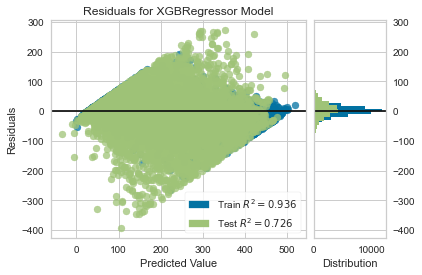

In [23]:
plot_model(xgb)

In [24]:
tuned_xgb= tune_model(xgb, fold = 5, search_library = 'scikit-optimize',
                      search_algorithm = 'bayesian', n_iter = 100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,29.6038,2198.5171,46.8883,0.7357,0.3050,0.2431
1,30.0143,2278.9951,47.7388,0.7342,0.3041,0.2427
2,30.1934,2360.1633,48.5815,0.7208,0.3107,0.2473
3,29.3386,2176.0208,46.6478,0.7467,0.2972,0.2371
4,30.3703,2340.4810,48.3785,0.7218,0.3096,0.2474
Mean,29.9041,2270.8354,47.6470,0.7318,0.3053,0.2435
Std,0.3803,73.6428,0.7734,0.0096,0.0048,0.0038


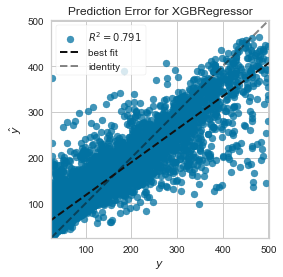

In [18]:
plot_model(tuned_xgb,  plot = 'error')

In [6]:
lgb = create_model('lightgbm')
tuned_lgb= tune_model(lgb, fold = 3, search_library = 'scikit-optimize',
                      search_algorithm = 'bayesian', n_iter = 100)# fit_params = {'objective': 'quantile', 'alpha':0.5}

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,32.1240,2556.8349,50.5652,0.7031,0.3217,0.2626
1,31.4769,2429.7802,49.2928,0.7121,0.3154,0.2557
2,31.4948,2396.5061,48.9541,0.7156,0.3183,0.2604
Mean,31.6986,2461.0404,49.6040,0.7103,0.3185,0.2596
Std,0.3009,69.0856,0.6935,0.0053,0.0026,0.0029


In [ ]:
df_lgb = pd.DataFrame.from_dict(tuned_lgb.get_params(), orient = 'index')
df_lgb.to_csv("lgb_tune.csv")
df_lgb

,0
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.072109
max_depth,-1
min_child_samples,1
min_child_weight,0.001
min_split_gain,0.381378
n_estimators,300


In [ ]:
# tune et
et = create_model('et')
tuned_lgb= tune_model(et, fold = 3, search_library = 'scikit-optimize',
                      search_algorithm = 'bayesian', n_iter = 100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,28.4953,2243.4663,47.3652,0.7382,0.3009,0.2333
1,28.5901,2273.2751,47.6789,0.7337,0.3046,0.2368
2,27.5411,2128.0474,46.1308,0.7491,0.2843,0.2156
3,27.3075,2024.3357,44.9926,0.7617,0.2857,0.2179
4,28.1565,2187.7195,46.7731,0.7388,0.2980,0.2307
Mean,28.0181,2171.3688,46.5881,0.7443,0.2947,0.2269
Std,0.5112,88.7082,0.9574,0.0100,0.0082,0.0085


IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:04:31
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,Fold,MAE,MSE,RMSE,R2,RMSLE,MAPE


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 14.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 12.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
